## The effect of adding object terms in the multiple linear regression model
This code will compare model performance and multicollinearity after adding object terms (e.g., 1 for boy and 0 for others)

In [3]:
import os
from pathlib import Path
import numpy as np
import pandas as pd

from scipy import stats
from scipy.stats.mstats import zscore

from scipy.ndimage import gaussian_filter
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant

import pingouin as pg

import matplotlib as mpl
import matplotlib.pyplot as plt  

import seaborn as sns

from datetime import date
import time

import random

from joblib import Parallel, delayed

import h5py

In [4]:
# no top and right spines in all plots
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [5]:
mother_path = Path('D:/Multi-modal project/')

### Parameter setting

In [6]:
num_iter = 1000

gauss_sigma = 2

# colors for multimodal, visual, auditory, control conditions
color = ['tab:purple','tab:blue','tab:red','tab:green']
color2 = ['cyan','magenta','brown']
linestyle = ['-',':']

today = str(date.today())

### Data preparation

In [9]:
# selectivity data
data_path = mother_path /'analysis'/'result'/'3. ANOVA'/'2023-07-10'
f = h5py.File(data_path/'2023-07-10_ANOVA_result.hdf5','r')

# regression data (standard)
data1_path = mother_path /'analysis'/'result'/'3.1 Multiple linear regression'/'2023-07-10'
f1 = h5py.File(data1_path/'2023-07-10_multiple_regression_result.hdf5','r')

# regression data (aligned to response end)
data2_path = mother_path /'analysis'/'result'/'3.1 Multiple linear regression'/'2024-03-01'
f2 = h5py.File(data2_path/'2024-03-01_multiple_regression_result.hdf5','r')

### Data analysis

In [13]:
def h5_to_df(f):
    keys = list(f.keys())
    attributes = {}
    
    for key in keys:
        attributes[key] = dict(f[key].attrs.items())
    
    df = pd.DataFrame.from_dict(attributes, orient='index')
    df.index.name = 'key'
    df = df.reset_index()
    
    return df

In [ ]:
df = h5_to_df(f1)
df = df1[(df1['region']=='PER')]
df.reset_index(inplace=True,drop=True)

for key in df['key']:    
    df.loc[df1['key']==key,'pref_obj'] = f[key].attrs['preferred object']
    df.loc[df1['key']==key,'peak_selectivity'] = np.max(f[f'{key}/anova_eta'])  
    df.loc[df1['key']==key,'peak_selectivity_time'] = f[key].attrs['peak selectivity time']
    df.loc[df1['key']==key,'selectivity_duration'] = len(f[f'{key}/object_bin'])*10
    df.loc[df1['key']==key,'selectivity_onset'] = np.min(f[f'{key}/object_bin'])*10
    df.loc[df1['key']==key,'selectivity_index'] = np.abs(f[key].attrs['selectivity index'])
            
df['peak_selectivity_time_range'] = (df['peak_selectivity_time'] // 100) + 1
df['selectivity_onset_range'] = (df['peak_selectivity_time'] // 100) + 1

for i in range(len(df1)):
    if df.loc[i,'peak_selectivity_time'] < 200:
        df.loc[i,'peak_selectivity_time_range2'] = 0
    elif 200 <= df.loc[i,'peak_selectivity_time'] < 400:
        df.loc[i,'peak_selectivity_time_range2'] = 1
    elif 400 <= df.loc[i,'peak_selectivity_time'] < 650:
        df.loc[i,'peak_selectivity_time_range2'] = 2
    elif 650 <= df.loc[i,'peak_selectivity_time'] < 900:
        df.loc[i,'peak_selectivity_time_range2'] = 3

### Comparing the model comparison metrics after adding object terms
AIC, BIC, r-squared, adjusted r-suqared will be compared between two models

In [37]:
for i in range(len(df)):
    key = df.loc[i, 'key']
    df.loc[i, 'AIC'] = f2[f'{key}/basic/AIC'][()]
    df.loc[i, 'BIC'] = f2[f'{key}/basic/BIC'][()]
    df.loc[i, 'rsquared'] = f2[f'{key}/basic/rsquared'][()]
    df.loc[i, 'rsquared_adj'] = f2[f'{key}/basic/rsquared_adj'][()]

    df.loc[i, 'AIC_obj'] = f2[f'{key}/object/AIC'][()]
    df.loc[i, 'BIC_obj'] = f2[f'{key}/object/BIC'][()]
    df.loc[i, 'rsquared_obj'] = f2[f'{key}/object/rsquared'][()]
    df.loc[i, 'rsquared_adj_obj'] = f2[f'{key}/object/rsquared_adj'][()]

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-6.131894,148,two-sided,7.526725e-09,"[-1.72, -0.88]",0.024976,1.3e+06,0.060575


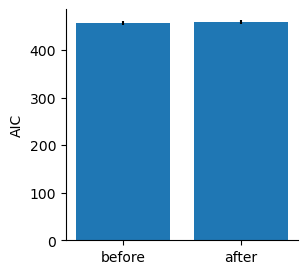

In [62]:
fig, ax = plt.subplots(figsize=(3,3))

x = ['before', 'after']
y = df.loc[df['response cell']==0,['AIC', 'AIC_obj']].mean()
yerr = df.loc[df['response cell']==0,['AIC', 'AIC_obj']].sem()
ax.bar(x=x, height=y)
ax.errorbar(x=x, y=y, yerr=yerr, fmt='none', color='black')
ax.set_ylabel('AIC')

pg.ttest(df.loc[df['response cell']==0, 'AIC'], df.loc[df['response cell']==0, 'AIC_obj'], paired=True)

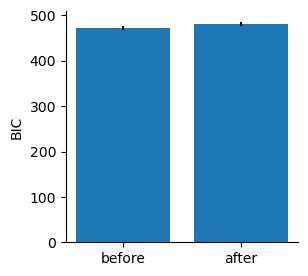

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-36.046504,148,two-sided,3.598187e-75,"[-7.91, -7.09]",0.142263,3.031e+71,0.407338


In [50]:
fig, ax = plt.subplots(figsize=(3,3))

x = ['before', 'after']
y = df.loc[df['response cell']==0,['BIC', 'BIC_obj']].mean()
yerr = df.loc[df['response cell']==0,['BIC', 'BIC_obj']].sem()
ax.bar(x=x, height=y)
ax.errorbar(x=x, y=y, yerr=yerr, fmt='none', color='black')
ax.set_ylabel('BIC')

plt.show()

pg.ttest(df.loc[df['response cell']==0, 'BIC'], df.loc[df['response cell']==0, 'BIC_obj'], paired=True)

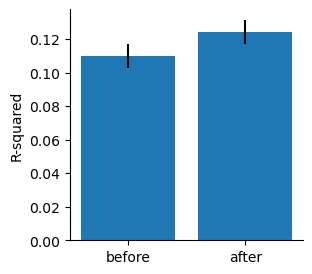

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-13.543695,148,two-sided,1.077555e-27,"[-0.02, -0.01]",0.163153,3.276e+24,0.507477


In [51]:
fig, ax = plt.subplots(figsize=(3,3))

x = ['before', 'after']
y = df.loc[df['response cell']==0,['rsquared', 'rsquared_obj']].mean()
yerr = df.loc[df['response cell']==0,['rsquared', 'rsquared_obj']].sem()
ax.bar(x=x, height=y)
ax.errorbar(x=x, y=y, yerr=yerr, fmt='none', color='black')
ax.set_ylabel('R-squared')

plt.show()

pg.ttest(df.loc[df['response cell']==0, 'rsquared'], df.loc[df['response cell']==0, 'rsquared_obj'], paired=True)

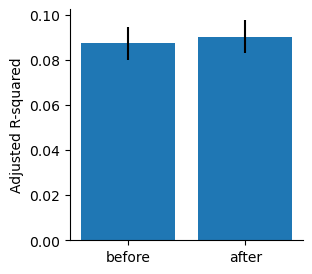

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-2.608949,148,two-sided,0.010014,"[-0.01, -0.0]",0.032128,2.393,0.067566


In [63]:
fig, ax = plt.subplots(figsize=(3,3))

x = ['before', 'after']
y = df.loc[df['response cell']==0,['rsquared_adj', 'rsquared_adj_obj']].mean()
yerr = df.loc[df['response cell']==0,['rsquared_adj', 'rsquared_adj_obj']].sem()
ax.bar(x=x, height=y)
ax.errorbar(x=x, y=y, yerr=yerr, fmt='none', color='black')
ax.set_ylabel('Adjusted R-squared')

plt.show()

pg.ttest(df.loc[df['response cell']==0, 'rsquared_adj'], df.loc[df['response cell']==0, 'rsquared_adj_obj'], paired=True)

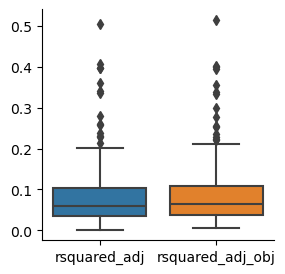

,W-val,alternative,p-val,RBC,CLES
Wilcoxon,4937.0,two-sided,0.218019,-0.116421,0.488086


In [68]:
fig, ax = plt.subplots(figsize=(3,3))

sns.boxplot(data=df.loc[df['response cell'] == 0, ['rsquared_adj', 'rsquared_adj_obj']], ax=ax)
#ax.set_ylabel('Adjusted R-squared')

plt.show()

pg.wilcoxon(df.loc[df['response cell']==0, 'rsquared_adj'], df.loc[df['response cell']==0, 'rsquared_adj_obj'])

### Comparing the multicollinearity after adding the object terms
Using variance inflation factors (VIFs)

In [80]:
# VIF data preparation
for i in range(len(df)):
    key = df.loc[i, 'key']
    if df.loc[i, 'pref_obj'] == 'Boy':
        
        df.loc[i, 'VIF_beta1'] = f2[f'{key}/basic/VIF'][1]
        df.loc[i, 'VIF_beta1_obj'] = f2[f'{key}/object/VIF'][2]
        
        df.loc[i, 'VIF_beta2'] = f2[f'{key}/basic/VIF'][2]
        df.loc[i, 'VIF_beta2_obj'] = f2[f'{key}/object/VIF'][3]
        
        df.loc[i, 'VIF_max'] = np.max(f2[f'{key}/basic/VIF'])
        df.loc[i, 'VIF_obj'] = f2[f'{key}/object/VIF'][1]
        
    elif df.loc[i, 'pref_obj'] == 'Egg':
        
        df.loc[i, 'VIF_beta1'] = f2[f'{key}/basic/VIF'][3]
        df.loc[i, 'VIF_beta1_obj'] = f2[f'{key}/object/VIF'][5]
        
        df.loc[i, 'VIF_beta2'] = f2[f'{key}/basic/VIF'][4]
        df.loc[i, 'VIF_beta2_obj'] = f2[f'{key}/object/VIF'][6]
        
        df.loc[i, 'VIF_max'] = np.max(f2[f'{key}/basic/VIF'])
        df.loc[i, 'VIF_obj'] = f2[f'{key}/object/VIF'][4]

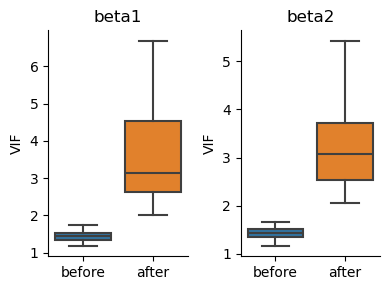

==================== beta1 ====================
          W-val alternative         p-val  RBC  CLES
Wilcoxon    0.0   two-sided  3.347423e-26 -1.0   0.0

==================== beta2 ====================
          W-val alternative         p-val  RBC  CLES
Wilcoxon    0.0   two-sided  3.347423e-26 -1.0   0.0


In [90]:
# comparing VIFs of beta1 and beta2
fig, ax = plt.subplots(1,2,figsize=(4,3))

sns.boxplot(data=df.loc[df['response cell'] == 0, ['VIF_beta1', 'VIF_beta1_obj']], ax=ax[0])
ax[0].set_ylabel('VIF')
ax[0].set_title('beta1')
ax[0].set_xticks([0, 1])
ax[0].set_xticklabels(['before', 'after'])

sns.boxplot(data=df.loc[df['response cell'] == 0, ['VIF_beta2', 'VIF_beta2_obj']], ax=ax[1])
ax[1].set_ylabel('VIF')
ax[1].set_title('beta2')
ax[1].set_xticks([0, 1])
ax[1].set_xticklabels(['before', 'after'])

plt.tight_layout()
plt.show()

vif_beta1 = pg.wilcoxon(df.loc[df['response cell']==0, 'VIF_beta1'], df.loc[df['response cell']==0, 'VIF_beta1_obj'])
vif_beta2 = pg.wilcoxon(df.loc[df['response cell']==0, 'VIF_beta2'], df.loc[df['response cell']==0, 'VIF_beta2_obj'])

print('==================== beta1 ====================')
print(vif_beta1)
print('')
print('==================== beta2 ====================')
print(vif_beta2)

In [70]:
# comparing the maximum VIFs in the previous model and the VIF of newly added object terms
# comparing VIFs of beta1 and beta2
fig, ax = plt.subplots(1,2,figsize=(4,3))

sns.boxplot(data=df.loc[df['response cell'] == 0, ['VIF_max', 'VIF_object']], ax=ax[0])
ax[0].set_ylabel('VIF')
ax[0].set_title('beta1')
ax[0].set_xticks([0, 1])
ax[0].set_xticklabels(['before', 'after'])

sns.boxplot(data=df.loc[df['response cell'] == 0, ['VIF_max', 'VIF_object']], ax=ax[1])
ax[1].set_ylabel('VIF')
ax[1].set_title('beta2')
ax[1].set_xticks([0, 1])
ax[1].set_xticklabels(['before', 'after'])

plt.tight_layout()
plt.show()

vif_beta1 = pg.wilcoxon(df.loc[df['response cell']==0, 'VIF_beta1'], df.loc[df['response cell']==0, 'VIF_beta1_obj'])
vif_beta2 = pg.wilcoxon(df.loc[df['response cell']==0, 'VIF_beta2'], df.loc[df['response cell']==0, 'VIF_beta2_obj'])

print('==================== beta1 ====================')
print(vif_beta1)
print('')
print('==================== beta2 ====================')
print(vif_beta2)